# Decision Trees (CART) for Steering Classification

This notebook trains and evaluates Classification and Regression Trees (CART) on the steering image dataset.

**Key Concepts:**
- Recursively partition feature space into rectangles
- Highly interpretable (mimics human decision-making)
- Captures non-linear relationships and interactions automatically
- Prone to overfitting without pruning


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

# Note: Decision trees don't require scaling or PCA
# But PCA can help with raw features to reduce computation
print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False  # Trees don't need scaling
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}
Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Hyperparameter Tuning (Tree Pruning)

Use cross-validation to find optimal max_depth (cost-complexity pruning).
- Deep trees: Low bias, high variance (overfitting)
- Shallow trees: High bias, low variance (underfitting)


In [3]:
# Grid search for optimal hyperparameters
print("Tuning Decision Tree on RAW (PCA) features...")

param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_raw = DecisionTreeClassifier(
    criterion='gini',
    class_weight='balanced',
    random_state=RANDOM_STATE
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search_raw = GridSearchCV(
    dt_raw, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

print(f"\nBest parameters: {grid_search_raw.best_params_}")
print(f"Best CV F1 score: {grid_search_raw.best_score_:.4f}")


Tuning Decision Tree on RAW (PCA) features...
Fitting 5 folds for each of 63 candidates, totalling 315 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV F1 score: 0.8287


In [4]:
# Grid search for ENGINEERED features
print("Tuning Decision Tree on ENGINEERED features...")

grid_search_eng = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', class_weight='balanced', random_state=RANDOM_STATE),
    param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

print(f"\nBest parameters: {grid_search_eng.best_params_}")
print(f"Best CV F1 score: {grid_search_eng.best_score_:.4f}")


Tuning Decision Tree on ENGINEERED features...
Fitting 5 folds for each of 63 candidates, totalling 315 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best CV F1 score: 0.7748


## 3. Evaluate Best Models


Evaluating best Decision Tree on RAW (PCA) features...

Model: Decision Tree | Features: raw
Accuracy:          0.8768
Balanced Accuracy: 0.8370
Macro F1:          0.8194
Weighted F1:       0.8778
Macro Precision:   0.8047
Macro Recall:      0.8370
ROC-AUC (macro):   0.8786

Per-class metrics:
  forward   : F1=0.9161, Precision=0.9256, Recall=0.9067
  left      : F1=0.7581, Precision=0.7569, Recall=0.7593
  right     : F1=0.7841, Precision=0.7315, Recall=0.8449

Classification Report:
              precision    recall  f1-score   support

     forward       0.93      0.91      0.92      1469
        left       0.76      0.76      0.76       324
       right       0.73      0.84      0.78       187

    accuracy                           0.88      1980
   macro avg       0.80      0.84      0.82      1980
weighted avg       0.88      0.88      0.88      1980



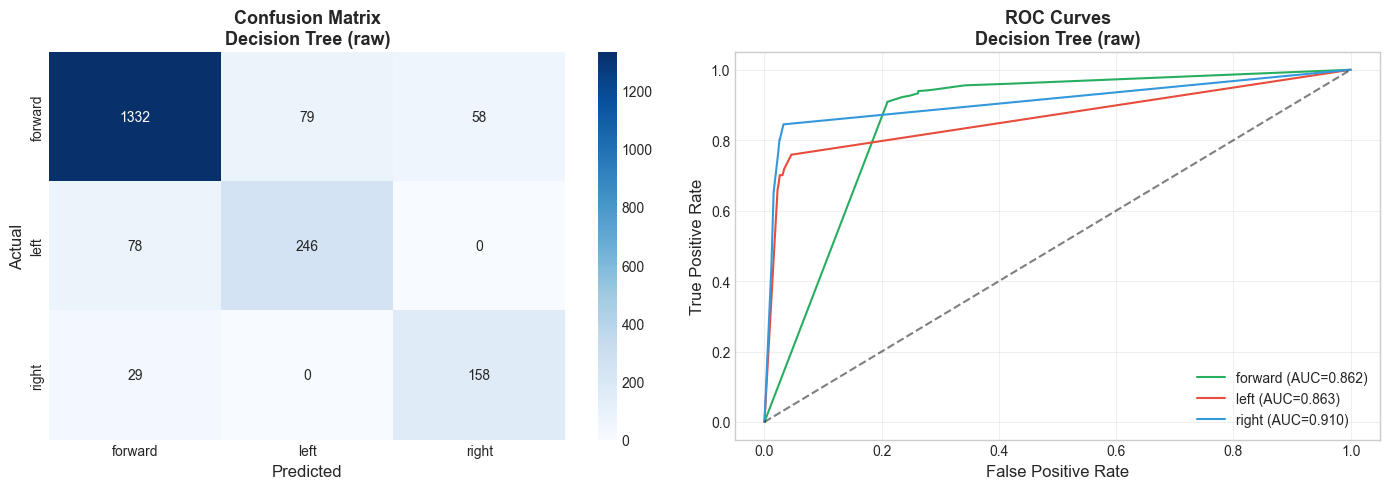

In [5]:
# Evaluate best model on RAW features
print("Evaluating best Decision Tree on RAW (PCA) features...")

best_dt_raw = grid_search_raw.best_estimator_

results_dt_raw = evaluate_model(
    best_dt_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='Decision Tree',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Evaluating best Decision Tree on ENGINEERED features...

Model: Decision Tree | Features: engineered
Accuracy:          0.8384
Balanced Accuracy: 0.7697
Macro F1:          0.7591
Weighted F1:       0.8399
Macro Precision:   0.7494
Macro Recall:      0.7697
ROC-AUC (macro):   0.8256

Per-class metrics:
  forward   : F1=0.8899, Precision=0.8998, Recall=0.8802
  left      : F1=0.7034, Precision=0.6801, Recall=0.7284
  right     : F1=0.6841, Precision=0.6684, Recall=0.7005

Classification Report:
              precision    recall  f1-score   support

     forward       0.90      0.88      0.89      1469
        left       0.68      0.73      0.70       324
       right       0.67      0.70      0.68       187

    accuracy                           0.84      1980
   macro avg       0.75      0.77      0.76      1980
weighted avg       0.84      0.84      0.84      1980



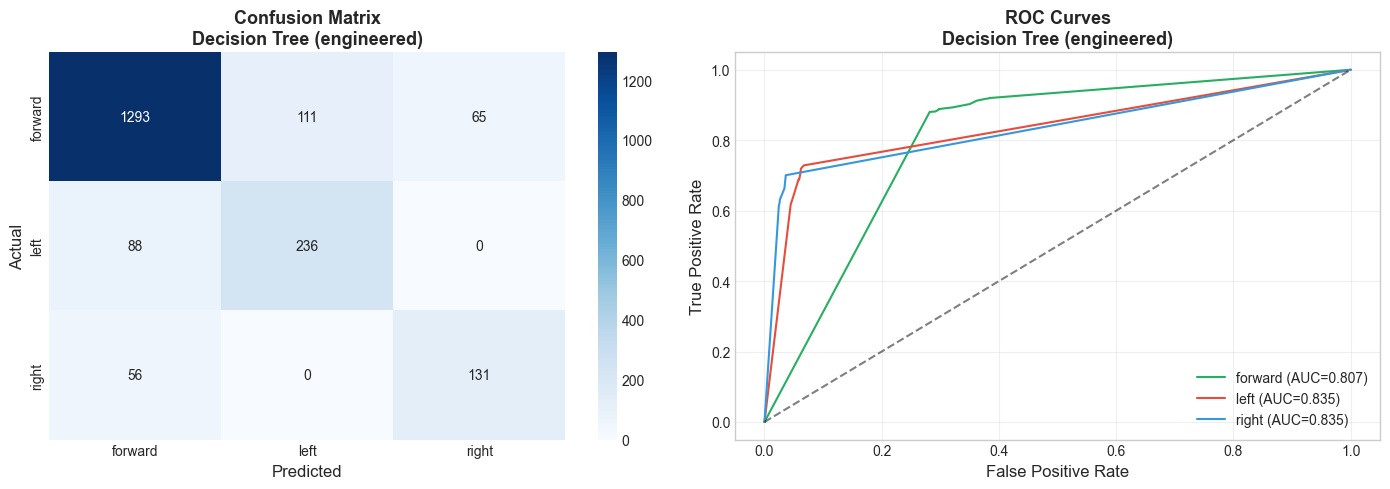

In [6]:
# Evaluate best model on ENGINEERED features
print("Evaluating best Decision Tree on ENGINEERED features...")

best_dt_eng = grid_search_eng.best_estimator_

results_dt_eng = evaluate_model(
    best_dt_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='Decision Tree',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 4. Visualize Tree and Feature Importance


Feature Importance (Engineered Features):
   1. brightness_center_x      : 0.3271
   2. quad_bl_mean             : 0.1856
   3. quad_br_mean             : 0.0881
   4. edge_mean                : 0.0541
   5. diag_asymmetry           : 0.0496
   6. edge_hv_ratio            : 0.0231
   7. kurtosis                 : 0.0189
   8. tb_diff                  : 0.0162
   9. quad_tr_mean             : 0.0145
  10. percentile_75            : 0.0144
  11. intensity_mean           : 0.0140
  12. canny_density            : 0.0126
  13. percentile_90            : 0.0125
  14. hog_max                  : 0.0119
  15. skewness                 : 0.0105


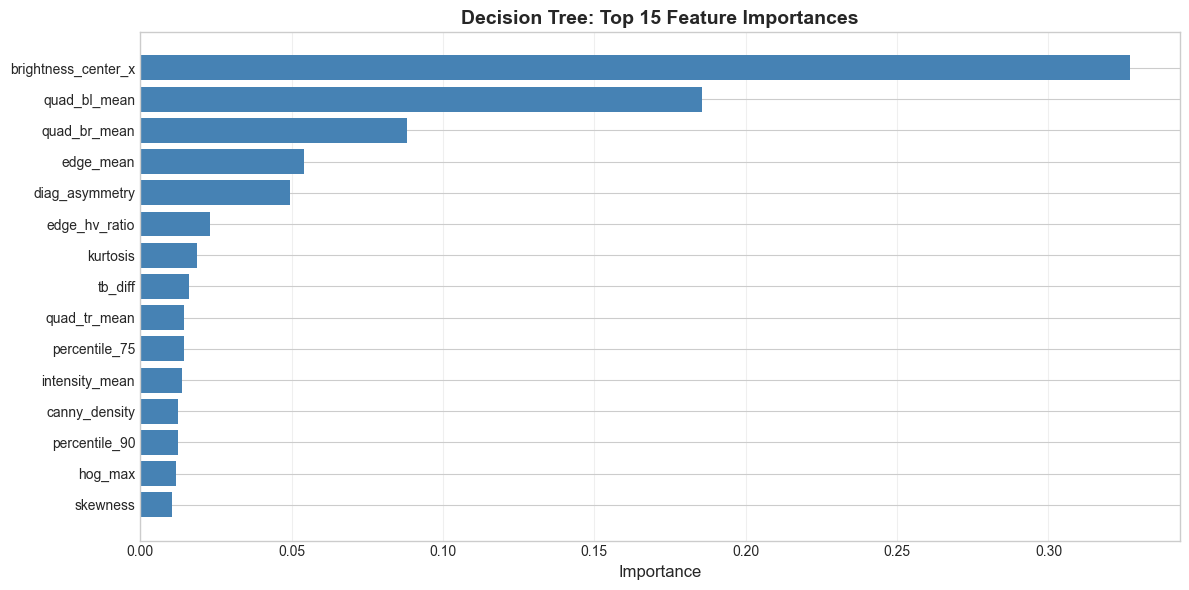

In [7]:
# Feature importance for engineered features
print("Feature Importance (Engineered Features):")
print("="*50)

importances = best_dt_eng.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(min(15, len(feature_names))):
    idx = indices[i]
    print(f"  {i+1:2d}. {feature_names[idx]:25s}: {importances[idx]:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
top_n = 15
top_indices = indices[:top_n]

ax.barh(range(top_n), importances[top_indices], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in top_indices])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Decision Tree: Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


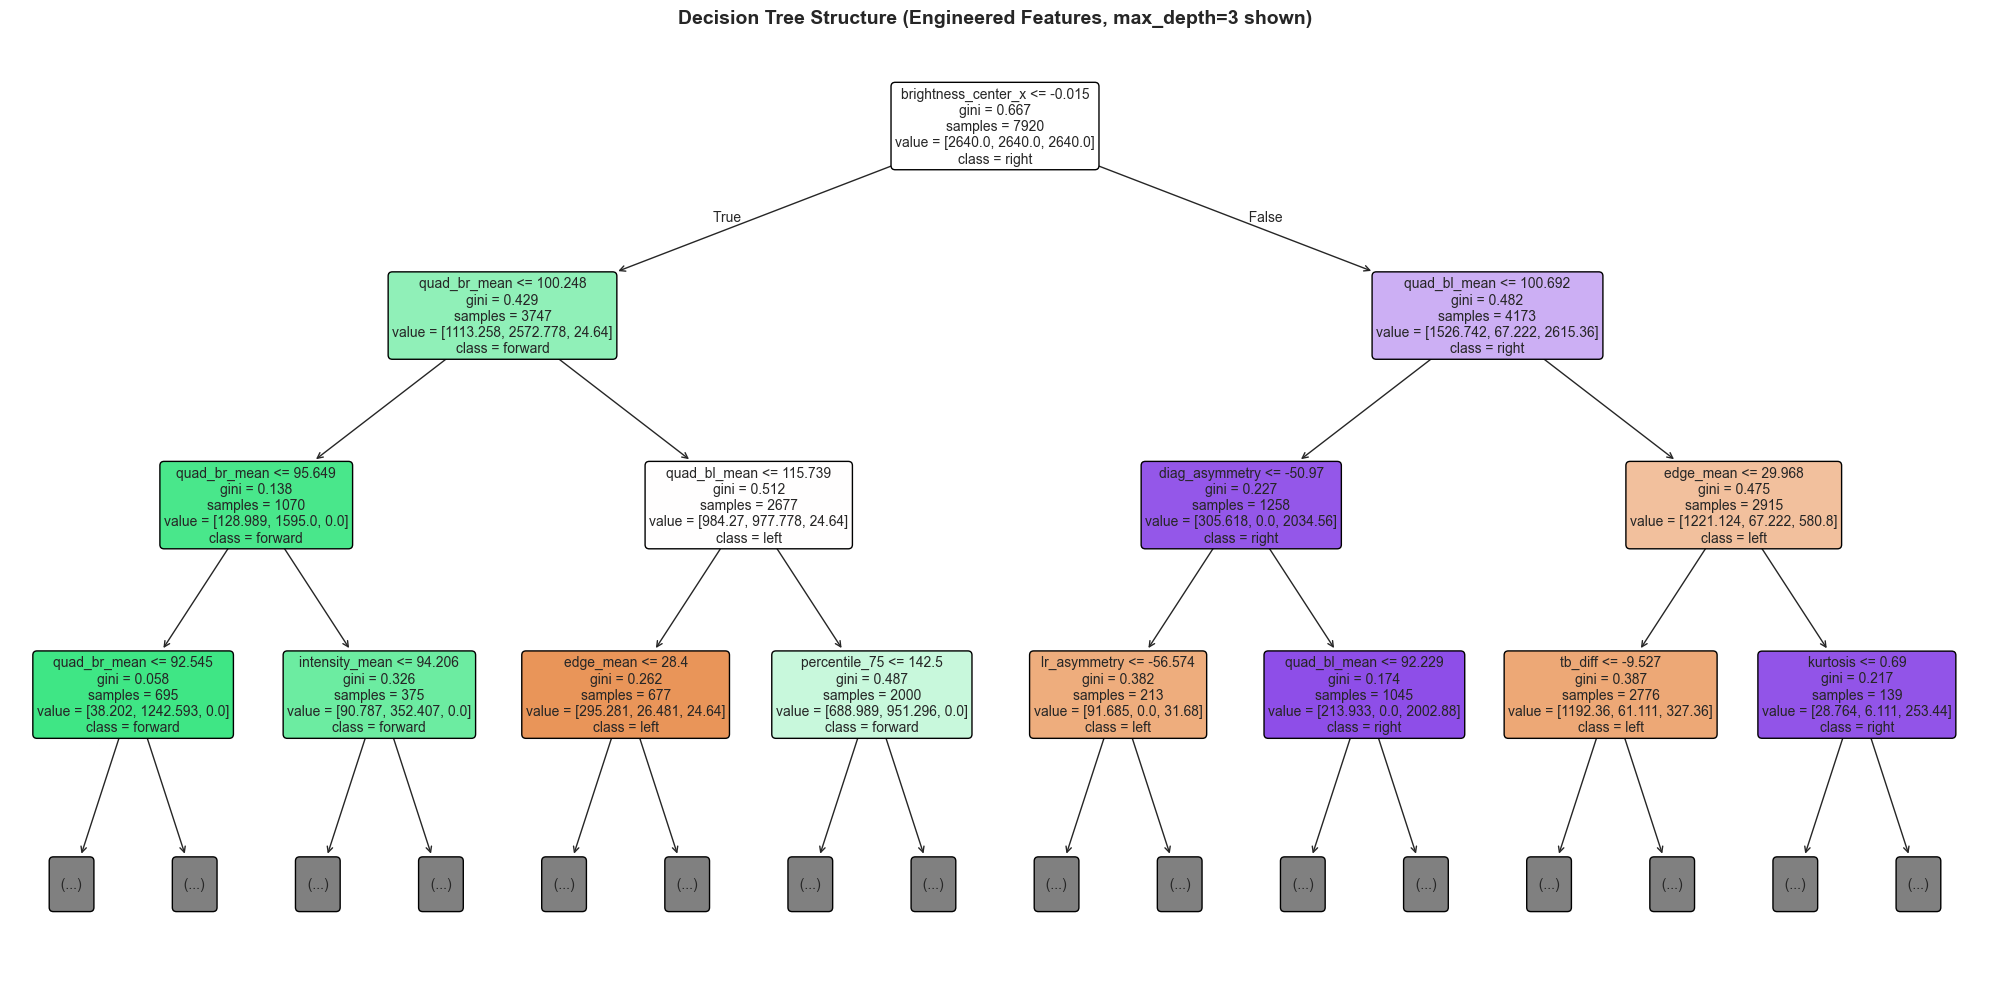

In [8]:
# Visualize tree structure (limited depth for readability)
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(best_dt_eng, 
          feature_names=feature_names,
          class_names=CLASSES,
          filled=True,
          rounded=True,
          max_depth=3,  # Limit for readability
          fontsize=10,
          ax=ax)

plt.title('Decision Tree Structure (Engineered Features, max_depth=3 shown)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Results Summary


In [9]:
# Summary
all_results = [results_dt_raw, results_dt_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("DECISION TREE RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



DECISION TREE RESULTS SUMMARY
        Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
Decision Tree        raw  0.876768      0.836973    0.819434 0.878620
Decision Tree engineered  0.838384      0.769707    0.759128 0.825643


In [10]:
# Save results
save_results(all_results, 'decision_tree')
print("Results saved successfully!")


Results saved to ../../data/model_results/decision_tree_results.json
Results saved successfully!


## 6. Key Observations

### Tree Pruning
- `max_depth` controls tree complexity
- `min_samples_split` and `min_samples_leaf` prevent overfitting to noise
- Cost-complexity pruning (alpha) is an alternative approach

### Interpretability
- Decision trees are highly interpretable
- Feature importance shows which features drive predictions
- Tree structure reveals decision logic

### Limitations
- Single trees are unstable (high variance)
- Small changes in data can lead to very different trees
- This motivates ensemble methods (Bagging, Random Forest)
